In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict, Counter
from sklearn.decomposition import TruncatedSVD
import itertools
from scipy.stats import linregress
import plotly_express as px
import torch.nn.functional as F
import math
import seaborn as sns

## Setup

In [2]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def comp_js_divergence(
    p_logit: Float[torch.Tensor, "*batch vocab"],
    q_logit: Float[torch.Tensor, "*batch vocab"],
) -> Float[torch.Tensor, "*batch"]:
    p_logprob = torch.log_softmax(p_logit, dim=-1)
    q_logprob = torch.log_softmax(q_logit, dim=-1)
    p = p_logprob.exp()
    q = q_logprob.exp()

    # convert to log2
    p_logprob *= math.log2(math.e)
    q_logprob *= math.log2(math.e)

    m = 0.5 * (p + q)
    m_logprob = m.log2()

    p_kl_div = (p * (p_logprob - m_logprob)).sum(-1)
    q_kl_div = (q * (q_logprob - m_logprob)).sum(-1)

    assert p_kl_div.isfinite().all()
    assert q_kl_div.isfinite().all()
    return (p_kl_div + q_kl_div) / 2


def find_js_dist_blowup_max_slope(
    js_dists: List[float], min_slope_threshold: float = 0.02
):
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    if not any(np.array(slopes) > min_slope_threshold):
        return len(steps) - 1

    return np.argsort(np.nan_to_num(slopes))[::-1][0]


def find_js_dist_blowup(
    js_dists: List[float],
    slope_threshold: float = 1.25,
    min_js_distance: float = 0.1,
    min_slope_threshold: float = 0.02,
) -> int:
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    for i in range(1, len(steps)):
        current_slope = slopes[i]
        prev_slope = slopes[i - 1]

        # print(f"step={i}, {current_slope=} {prev_slope=}, {slope_threshold * max(prev_slope, 1e-6)}")

        # Check if we're in an increasing trend and above minimum JS distance
        if (
            current_slope > (slope_threshold * max(prev_slope, 1e-6))
            or current_slope >= min_slope_threshold
        ) and js_dists[i] >= min_js_distance:
            return i

    return len(steps) - 1


def find_plateau_length_js(
    js_dists: List[float], threshold: float = 5e-03, window_size: int = 5
) -> int:

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(js_dists) - window_size + 1):
        window = js_dists[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(js_dists) - 1


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act


def plot_heatmap_feature_acts(feature_activations, js_dists):
    # Assuming feature_activations is a PyTorch tensor
    feature_acts_np = (
        feature_activations.numpy()
    )  # Convert to numpy if it's not already

    # Identify top features from start and end
    n_top = 10
    start_top_features = np.argsort(feature_acts_np[0])[-n_top:][::-1]
    end_top_features = np.argsort(feature_acts_np[-1])[-n_top:][::-1]

    # Assume js_blowup_step is the time step where JS distance starts increasing rapidly
    js_blowup_step = find_js_dist_blowup(js_dists)  # Replace with your actual step

    # Combine and get unique features
    combined_features = np.unique(
        np.concatenate([start_top_features, end_top_features])
    )

    # Create labels for y-axis
    y_labels = []

    feature_ranks = []

    for feat in combined_features:
        start_rank = np.where(start_top_features == feat)[0]
        end_rank = np.where(end_top_features == feat)[0]
        feature_rank = 0

        label = f"F{feat}"
        if len(start_rank) > 0:
            label += f" (S-{start_rank[0]+1})"
            feature_rank += start_rank[0]
        else:
            feature_rank += n_top

        if len(end_rank) > 0:
            label += f" (E-{end_rank[0]+1})"
            if len(start_rank) == 0:
                feature_rank += 10 + end_rank[0]

        y_labels.append(label)
        feature_ranks.append(feature_rank)

    sorted_feature_ranks = np.argsort(feature_ranks)
    sorted_y_labels = [y_labels[idx] for idx in sorted_feature_ranks]

    # Create heatmap
    fig, ax = plt.subplots(figsize=(20, len(combined_features) / 2 + 2))
    sns.heatmap(
        feature_acts_np[:, combined_features[sorted_feature_ranks]].T,
        cmap="coolwarm",
        cbar_kws={"label": "Activation"},
        yticklabels=sorted_y_labels,
        ax=ax,
    )

    # Add vertical line for JS distance blowup
    ax.axvline(x=js_blowup_step, color="white", linestyle="--", linewidth=2)

    # Add text annotation for the JS blowup line
    ax.text(
        js_blowup_step,
        len(combined_features) - 0.25,
        "JS Dist Blowup",
        rotation=90,
        va="bottom",
        ha="right",
        color="white",
        fontweight="normal",
    )

    # Assuming js_distances is your array of JS distances over time
    ax2 = ax.twinx()
    ax2.plot(js_dists, color="white", linewidth=2)
    ax2.set_ylabel("JS Distance", color="white")
    ax2.tick_params(axis="y", labelcolor="white")

    plt.title("Top Feature Activations Over Time (Start and End)")
    plt.xlabel("Time Steps")
    plt.ylabel("Feature ID (Start Rank, End Rank)")
    plt.tight_layout()
    plt.show()

In [3]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [4]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

## Load & Clean data

In [5]:
def classify_perturbation_type(js_dists: List[float]) -> str:
    # Check for initial plateau
    initial_js_dists = np.nan_to_num(js_dists[:10])
    initial_slope = linregress(range(10), initial_js_dists).slope
    diff = np.mean(
        [initial_js_dists[i + 1] - initial_js_dists[i] for i in range(10 - 1)]
    )

    # Check for rapid increase
    max_slope = max(js_dists[i + 1] - js_dists[i] for i in range(len(js_dists) - 1))

    if initial_slope < 0.01 and max_slope >= 0.1 and diff < 0.003:
        return "plateau_then_rapid"
    elif all(js_dists[i] <= js_dists[i + 1] for i in range(len(js_dists) - 1)):
        return "monotonic_increase"
    else:
        return "other"

In [6]:
metadata, activations = [], []

n_files = 50

for path in sorted(glob("observations/metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob("observations/acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [7]:
len(metadata), activations.shape

(25000, (25000, 100, 768))

In [8]:
# Clean data
clean_metadata = []
clean_activations = []

n_examples = 25_000
idxs = random.sample(range(len(metadata)), n_examples)

max_recon_error = 3.0
c = 0

for idx in idxs:
    m = metadata[idx]
    acts = activations[idx]
    js_dists = [s["js_dist"] for s in m["steps_metadata"]]

    pert_type = classify_perturbation_type(js_dists)

    if pert_type != "plateau_then_rapid":
        continue

    if js_dists[-1] - js_dists[0] < 0.1:
        continue

    if np.isnan(js_dists).sum() > 1:
        continue

    blowup_point = find_js_dist_blowup_max_slope(js_dists)

    if blowup_point >= len(js_dists) - 1 or blowup_point <= 1:
        continue

    act_recon = sae.decode(sae.encode(torch.tensor(acts[0])))
    recon_error = torch.tensor(acts[0]) - act_recon
    recon_error = recon_error.abs().sum(dim=-1).detach().numpy()

    if recon_error > max_recon_error:
        continue

    clean_metadata.append(m)
    clean_activations.append(acts)

    c += 1

    if c % 1000 == 0:
        print(c)

clean_activations = np.stack(clean_activations)

1000
2000
3000
4000
5000
6000
7000
8000
9000


In [9]:
len(clean_metadata), clean_activations.shape

(9879, (9879, 100, 768))

In [10]:
metadata = clean_metadata
activations = clean_activations

In [11]:
# with open('data/clean_metadata.json', 'w') as fw:
#     json.dump(metadata, fw)

# np.save('data/clean_activations.npy', activations)

In [5]:
with open("data/clean_metadata.json", "r") as fr:
    metadata = json.load(fr)

activations = np.load("data/clean_activations.npy")

In [6]:
len(metadata), activations.shape

(9879, (9879, 100, 768))

## Modelling

In [13]:
def find_crossover_point(feature_acts):
    start_feature = feature_acts[:, 0]
    end_feature = feature_acts[:, 1]

    # Compare absolute values
    mask = torch.abs(end_feature) > torch.abs(start_feature)

    # Find the first True value in the mask
    crossover_indices = torch.nonzero(mask)

    if crossover_indices.numel() > 0:
        return crossover_indices[0].item()
    else:
        return feature_acts.shape[0] // 2


def interpolate_features(steps):
    start_active_ids = steps[0]["active_feature_ids"]
    start_active_feat_acts = steps[0]["active_feature_acts"]

    end_active_ids = steps[-1]["active_feature_ids"]
    end_active_feat_acts = steps[-1]["active_feature_acts"]

    all_active_feature_ids = list(set(start_active_ids + end_active_ids))
    all_active_feats = {k: {"start": 0, "end": 0} for k in all_active_feature_ids}

    for f_id, f_act in zip(start_active_ids, start_active_feat_acts):
        all_active_feats[f_id]["start"] = f_act

    for f_id, f_act in zip(end_active_ids, end_active_feat_acts):
        all_active_feats[f_id]["end"] = f_act

    interpolated_feature_acts = []

    for i in range(len(steps)):
        f_act = torch.zeros(sae.W_enc.shape[1])
        for f_id in all_active_feature_ids:
            f_range = all_active_feats[f_id]
            step_size = (f_range["end"] - f_range["start"]) / 100
            feat_step_act = f_range["start"] + (step_size * i)
            f_act[f_id] = feat_step_act
        interpolated_feature_acts.append(f_act)
    interpolated_feature_acts = torch.stack(interpolated_feature_acts)
    return interpolated_feature_acts


def extract_crossover_point(feature_acts):
    top_features_start = torch.argsort(feature_acts[0])[-5:].flip(dims=(0,))
    top_features_end = torch.argsort(feature_acts[-1])[-5:].flip(dims=(0,))
    feature_ids = [top_features_start[0].item(), top_features_end[0].item()]
    crossover_point = find_crossover_point(feature_acts[:, feature_ids])
    return crossover_point


def get_data_for_step(steps):
    step_js_dists = [s["js_dist"] for s in steps]
    js_blowup_step = find_js_dist_blowup_max_slope(step_js_dists)
    sensitivity = 1 - js_blowup_step / len(step_js_dists)
    # feature_acts = get_feature_activations(steps)
    feature_acts = interpolate_features(steps)
    return feature_acts, step_js_dists, js_blowup_step, sensitivity


def get_feature_activations(steps):
    feature_activations = []
    for _, s in enumerate(steps):
        active_feature_ids = s["active_feature_ids"]
        active_feature_acts = s["active_feature_acts"]
        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
        feature_activations.append(feature_acts)
    return torch.stack(feature_activations)


def find_crossover_point_between_vectors(v1, v2):
    for i, (n1, n2) in enumerate(zip(v1, v2)):
        if n1 < n2:
            return i
    return len(v1)


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act


def calculate_auc(values):
    # Create x values corresponding to the indices of the values
    x = np.arange(len(values))

    # Use numpy's trapezoidal rule to calculate the area under the curve
    auc = np.trapz(values, x)

    return auc


def max_space_ratio_step(values):
    aucs = []
    for i in range(1, len(values)):
        auc = calculate_auc(values[:i])
        if auc == 0:
            aucs.append(0)
            continue
        triangle_area = (values[i - 1] * i) / 2
        aucs.append(triangle_area / auc)
    return np.argmax(aucs[5:]) + 5  # Hacky, but works. Wonky stuff at the start

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from scipy.stats import entropy
import cupy as cp
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from scipy.stats import entropy
import numpy as np
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from scipy.signal import find_peaks

In [14]:
import numpy as np
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from scipy.signal import find_peaks


def extract_advanced_activation_features(feature_acts):
    _, n_features = feature_acts.shape
    feature_acts = feature_acts.numpy()
    features = []

    for feat in range(n_features):
        sequence = feature_acts[:, feat]

        # 1. Frequency domain analysis
        fft_vals = np.abs(fft(sequence))
        dominant_freq = np.argmax(fft_vals[1:]) + 1  # Exclude DC component
        freq_magnitude = np.max(fft_vals[1:])  # Magnitude of dominant frequency

        # 2. Activation trajectory
        start_val = sequence[0]
        end_val = sequence[-1]
        max_val = np.max(sequence)
        min_val = np.min(sequence)
        range_val = max_val - min_val

        # 3. Statistical moments
        mean_val = np.mean(sequence)
        std_val = np.std(sequence)
        skewness = skew(sequence)
        kurt = kurtosis(sequence)

        # 4. Peaks and valleys analysis
        peaks, _ = find_peaks(sequence)
        valleys, _ = find_peaks(-sequence)
        n_peaks = len(peaks)
        n_valleys = len(valleys)
        peak_valley_ratio = n_peaks / n_valleys if n_valleys != 0 else n_peaks

        # 5. Activation speed
        activation_speed = np.mean(np.abs(np.diff(sequence)))

        # 6. Threshold crossing
        threshold = (max_val + min_val) / 2
        crossings = np.sum(np.diff((sequence > threshold).astype(int)) != 0)

        features.extend(
            [
                dominant_freq,
                freq_magnitude,
                start_val,
                end_val,
                max_val,
                min_val,
                range_val,
                mean_val,
                std_val,
                skewness,
                kurt,
                n_peaks,
                n_valleys,
                peak_valley_ratio,
                activation_speed,
                crossings,
            ]
        )

    # 7. Cross-feature analysis
    corr_matrix = np.corrcoef(feature_acts.T)
    mean_correlation = np.mean(np.abs(corr_matrix[np.triu_indices(n_features, k=1)]))

    # 9. Activation space volume
    volume = np.prod(np.max(feature_acts, axis=0) - np.min(feature_acts, axis=0))

    features.extend([mean_correlation, volume])

    return features


def bucket_and_compute_stats(data, num_buckets=3):
    # Ensure the data is a numpy array
    data = np.array(data)

    # Calculate the size of each bucket
    bucket_size = len(data) // num_buckets

    # Initialize lists to store results
    means = []

    # Bucket the data and compute statistics
    for i in range(num_buckets):
        start = i * bucket_size
        end = start + bucket_size if i < num_buckets - 1 else None
        bucket = data[start:end]

        means.append(np.mean(bucket))

    return means


def sae_feature_sparsity_features(steps, top_features_per_step):
    mean_fs_per_time_step = []
    std_fs_per_time_step = []

    for s in steps:
        active_feature_ids = s["active_feature_ids"]
        mean_spars = torch.mean(feature_sparsities[active_feature_ids])
        std_spars = torch.std(feature_sparsities[active_feature_ids])
        mean_fs_per_time_step.append(mean_spars.item())
        std_fs_per_time_step.append(std_spars.item())

    bucket_means = bucket_and_compute_stats(mean_fs_per_time_step)
    bucket_stds = bucket_and_compute_stats(std_fs_per_time_step)

    top_feature_spars_per_step = torch.stack(
        [feature_sparsities[t] for t in top_features_per_step]
    )

    mean_top_feature_spars = top_feature_spars_per_step.mean(dim=0).tolist()
    std_top_feature_spars = top_feature_spars_per_step.std(dim=0).tolist()

    sfs = [*bucket_means, *bucket_stds, *mean_top_feature_spars, *std_top_feature_spars]

    return sfs


def construct_features_and_label(steps, acts):
    feature_acts, step_js_dists, js_blowup_step, sensitivity = get_data_for_step(steps)
    n_steps = len(steps)

    # Find crossover point
    cp_point = extract_crossover_point(feature_acts)
    pred_sensitivity_cp = 1 - cp_point / len(steps)

    # Find top features start relevant info
    top_feature_ids_start = torch.argsort(feature_acts[0]).numpy()[::-1][:5].tolist()
    top_feature_acts_start = feature_acts[:, top_feature_ids_start]
    top_feature_acts_norm_start = (
        top_feature_acts_start / top_feature_acts_start.max(dim=0).values
    )
    top_feature_acts_start_mean = top_feature_acts_norm_start.mean(dim=-1)

    top_features_acts_start_slopes = (
        ((top_feature_acts_norm_start[-1] - top_feature_acts_norm_start[0]) / n_steps)
        .numpy()
        .tolist()
    )
    top_feature_acts_start_mean_slope = (
        (top_feature_acts_start_mean[-1] - top_feature_acts_start_mean[0]) / n_steps
    ).item()

    # Find top features end relevant info
    top_feature_ids_end = torch.argsort(feature_acts[-1]).numpy()[::-1][:5].tolist()
    top_feature_acts_end = feature_acts[:, top_feature_ids_end]
    top_feature_acts_norm_end = (
        top_feature_acts_end / top_feature_acts_end.max(dim=0).values
    )
    top_feature_acts_end_mean = top_feature_acts_norm_end.mean(dim=-1)

    top_features_acts_end_slopes = (
        ((top_feature_acts_norm_end[-1] - top_feature_acts_norm_end[0]) / n_steps)
        .numpy()
        .tolist()
    )
    top_feature_acts_end_mean_slope = (
        (top_feature_acts_end_mean[-1] - top_feature_acts_end_mean[0]) / n_steps
    ).item()

    # Crossover point between feature acts mean
    cp_point_mean_feats = find_crossover_point_between_vectors(
        top_feature_acts_start_mean, top_feature_acts_end_mean
    )

    # Feature dirs cosine
    start_act = torch.tensor(acts[0]).unsqueeze(0)
    end_act = torch.tensor(acts[-1]).unsqueeze(0)

    top_feature_dirs_start = torch.stack(
        [
            get_feature_dir(sae, fid, feature_acts[0, fid].item(), norm=False)
            for fid in top_feature_ids_start
        ]
    )
    top_feature_dirs_end = torch.stack(
        [
            get_feature_dir(sae, fid, feature_acts[-1, fid].item(), norm=False)
            for fid in top_feature_ids_end
        ]
    )

    # # Cosine similarity between top features from A with A
    # top_features_a_a_sim = (
    #     torch.cosine_similarity(start_act, top_feature_dirs_start)
    #     .detach()
    #     .numpy()
    #     .tolist()
    # )

    # # Cosine similarity between top features from A with T
    # top_features_a_t_sim = (
    #     torch.cosine_similarity(end_act, top_feature_dirs_start)
    #     .detach()
    #     .numpy()
    #     .tolist()
    # )

    # # Cosine similarity between top features from T with A
    # top_features_t_a_sim = (
    #     torch.cosine_similarity(start_act, top_feature_dirs_end)
    #     .detach()
    #     .numpy()
    #     .tolist()
    # )

    # # Cosine similarity between top features from T with T
    # top_features_t_t_sim = (
    #     torch.cosine_similarity(end_act, top_feature_dirs_end).detach().numpy().tolist()
    # )

    # # Cosine sim between top feature in A with top features in T
    # top_feature1_start_t_sim = torch.cosine_similarity(
    #     top_feature_dirs_start[0, :], top_feature_dirs_end
    # ).tolist()

    # # Cosine sim between top 2 feature in A with top features in T
    # top_feature2_start_t_sim = torch.cosine_similarity(
    #     top_feature_dirs_start[1, :], top_feature_dirs_end
    # ).tolist()

    # # Cosine sim between top 3 feature in A with top features in T
    # top_feature3_start_t_sim = torch.cosine_similarity(
    #     top_feature_dirs_start[2, :], top_feature_dirs_end
    # ).tolist()

    # # Cosine sim between top 4 feature in A with top features in T
    # top_feature4_start_t_sim = torch.cosine_similarity(
    #     top_feature_dirs_start[3, :], top_feature_dirs_end
    # ).tolist()

    # # Cosine sim between top 5 feature in A with top features in T
    # top_feature5_start_t_sim = torch.cosine_similarity(
    #     top_feature_dirs_start[4, :], top_feature_dirs_end
    # ).tolist()

    features = [
        pred_sensitivity_cp,
        *top_features_acts_start_slopes,
        top_feature_acts_start_mean_slope,
        *top_features_acts_end_slopes,
        top_feature_acts_end_mean_slope,
        cp_point_mean_feats,
        # *top_features_a_a_sim,
        # *top_features_a_t_sim,
        # *top_features_t_a_sim,
        # *top_features_t_t_sim,
        # *top_feature1_start_t_sim,
        # *top_feature2_start_t_sim,
        # *top_feature3_start_t_sim,
        # *top_feature4_start_t_sim,
        # *top_feature5_start_t_sim
    ]

    # Reintroduce gradient and acceleration features
    row_indices = np.arange(feature_acts.shape[0])[:, np.newaxis]
    top_features_per_step = np.argsort(feature_acts)[:, -5:].flip(dims=(0,))
    top_features_acts = feature_acts[row_indices, top_features_per_step]

    gradients = np.gradient(top_features_acts, axis=0)
    accelerations = np.gradient(gradients, axis=0)

    max_gradient = np.max(np.abs(gradients), axis=1)
    pred_step_grad = np.argsort(max_gradient)[::-1][0]
    pred_sensitivity_grad = 1 - pred_step_grad / len(steps)

    # Calculate mean and max of gradients and accelerations
    mean_gradient = np.mean(np.abs(gradients))
    max_acceleration = np.max(np.abs(accelerations))
    mean_acceleration = np.mean(np.abs(accelerations))

    # L2 norm calculations
    perturbation = acts[-1] - acts[0]
    l2_norm_perturbation = np.linalg.norm(perturbation)
    l2_norm_start = np.linalg.norm(acts[0])
    l2_norm_end = np.linalg.norm(acts[-1])

    # Ratio of perturbation to starting activation
    l2_norm_ratio_start = (
        l2_norm_perturbation / l2_norm_start if l2_norm_start != 0 else 0
    )

    # Ratio of perturbation to ending activation
    l2_norm_ratio_end = l2_norm_perturbation / l2_norm_end if l2_norm_end != 0 else 0

    # Add new features to the list
    new_features = [
        pred_sensitivity_grad,
        mean_gradient,
        max_acceleration,
        mean_acceleration,
        l2_norm_perturbation,
        l2_norm_ratio_start,
        l2_norm_ratio_end,
    ]

    features.extend(new_features)

    adv_features = extract_advanced_activation_features(top_features_acts)

    features.extend(adv_features)

    # Sparsity features
    spars_features = sae_feature_sparsity_features(steps, top_features_per_step)
    features.extend(spars_features)

    return features, sensitivity, step_js_dists, js_blowup_step

In [11]:
# steps = metadata[0]["steps_metadata"]
# acts = activations[0]
# # features, label = construct_features_and_label(steps, acts)
# feature_acts, step_js_dists, js_blowup_step, sensitivity = get_data_for_step(steps)

# row_indices = np.arange(feature_acts.shape[0])[:, np.newaxis]
# top_features_per_step = np.argsort(feature_acts)[:, -5:].flip(dims=(0,))
# top_features_acts = feature_acts[row_indices, top_features_per_step]

In [15]:
adv_feature_name_templates = [
    "dominant_freq",
    "freq_magnitude",
    "start_val",
    "end_val",
    "max_val",
    "min_val",
    "mean_val",
    "range_val",
    "std_val",
    "skewness",
    "kurt",
    "n_peaks",
    "n_valleys",
    "peak_valley_ratio",
    "activation_speed",
    "crossings",
]

adv_feature_names = [
    *[
        f"rank_{i}_feat_{name}"
        for i in range(1, 6)
        for name in adv_feature_name_templates
    ],
    "cross_feature_mean_corr",
    "activation_space_volume",
]

feature_names = [
    "crossover_point_sens",
    "top_1_feat_start_slope",
    "top_2_feat_start_slope",
    "top_3_feat_start_slope",
    "top_4_feat_start_slope",
    "top_5_feat_start_slope",
    "top_feats_start_mean_slope",
    "top_1_feat_end_slope",
    "top_2_feat_end_slope",
    "top_3_feat_end_slope",
    "top_4_feat_end_slope",
    "top_5_feat_end_slope",
    "top_feats_end_mean_slope",
    "crossover_point_mean_feat_acts",
    # "top_1_feat_start_sim_a",
    # "top_2_feat_start_sim_a",
    # "top_3_feat_start_sim_a",
    # "top_4_feat_start_sim_a",
    # "top_5_feat_start_sim_a",
    # "top_1_feat_start_sim_t",
    # "top_2_feat_start_sim_t",
    # "top_3_feat_start_sim_t",
    # "top_4_feat_start_sim_t",
    # "top_5_feat_start_sim_t",
    # "top_1_feat_end_sim_a",
    # "top_2_feat_end_sim_a",
    # "top_3_feat_end_sim_a",
    # "top_4_feat_end_sim_a",
    # "top_5_feat_end_sim_a",
    # "top_1_feat_end_sim_t",
    # "top_2_feat_end_sim_t",
    # "top_3_feat_end_sim_t",
    # "top_4_feat_end_sim_t",
    # "top_5_feat_end_sim_t",
    # "top_1_feat_start_sim_top_1_feat_end",
    # "top_1_feat_start_sim_top_2_feat_end",
    # "top_1_feat_start_sim_top_3_feat_end",
    # "top_1_feat_start_sim_top_4_feat_end",
    # "top_1_feat_start_sim_top_5_feat_end",
    # "top_2_feat_start_sim_top_1_feat_end",
    # "top_2_feat_start_sim_top_2_feat_end",
    # "top_2_feat_start_sim_top_3_feat_end",
    # "top_2_feat_start_sim_top_4_feat_end",
    # "top_2_feat_start_sim_top_5_feat_end",
    # "top_3_feat_start_sim_top_1_feat_end",
    # "top_3_feat_start_sim_top_2_feat_end",
    # "top_3_feat_start_sim_top_3_feat_end",
    # "top_3_feat_start_sim_top_4_feat_end",
    # "top_3_feat_start_sim_top_5_feat_end",
    # "top_4_feat_start_sim_top_1_feat_end",
    # "top_4_feat_start_sim_top_2_feat_end",
    # "top_4_feat_start_sim_top_3_feat_end",
    # "top_4_feat_start_sim_top_4_feat_end",
    # "top_4_feat_start_sim_top_5_feat_end",
    # "top_5_feat_start_sim_top_1_feat_end",
    # "top_5_feat_start_sim_top_2_feat_end",
    # "top_5_feat_start_sim_top_3_feat_end",
    # "top_5_feat_start_sim_top_4_feat_end",
    # "top_5_feat_start_sim_top_5_feat_end",
    "pred_sensitivity_grad",
    "mean_gradient",
    "max_acceleration",
    "mean_acceleration",
    "l2_norm_perturbation",
    "l2_norm_ratio_start",
    "l2_norm_ratio_end",
    *adv_feature_names,
    "bucket_1_spars_means",
    "bucket_2_spars_means",
    "bucket_3_spars_means",
    "bucket_1_spars_stds",
    "bucket_2_spars_stds",
    "bucket_3_spars_stds",
    "rank_1_feat_mean_spars",
    "rank_2_feat_mean_spars",
    "rank_3_feat_mean_spars",
    "rank_4_feat_mean_spars",
    "rank_5_feat_mean_spars",
    "rank_1_feat_std_spars",
    "rank_2_feat_std_spars",
    "rank_3_feat_std_spars",
    "rank_4_feat_std_spars",
    "rank_5_feat_std_spars",
]

len(feature_names)

119

### Feature engineering

In [16]:
# n_examples = 6769
# idxs = random.sample(range(len(metadata)), n_examples)

idxs = range(len(metadata))

features, labels = [], []
js_dists, js_blowup_steps, js_dist_auc_blowup_step = [], [], []
l2_dists, l2_blowup_steps, l2_dist_auc_blowup_step = [], [], []

for idx in idxs:
    steps = metadata[idx]["steps_metadata"]
    acts = activations[idx]
    pert_features, pert_label, pert_js_dists, pert_js_blowup_step = (
        construct_features_and_label(steps, acts)
    )
    features.append(pert_features)

    # JS Dist
    labels.append(pert_js_blowup_step)
    js_dists.append(pert_js_dists)
    js_blowup_steps.append(pert_js_blowup_step)
    js_dist_auc_blowup_step.append(max_space_ratio_step(pert_js_dists))

    # L2
    pert_l2_dists = [s["read_layer_l2_norm"] for s in steps]
    l2_dists.append(pert_l2_dists)
    l2_blowup_step = find_js_dist_blowup_max_slope(pert_l2_dists)
    l2_blowup_steps.append(l2_blowup_step)
    l2_dist_auc_blowup_step.append(max_space_ratio_step(pert_l2_dists))

In [82]:
# Predict based on JS (AUC) blowup step
labels = l2_dist_auc_blowup_step

### Plotting histograms

In [23]:
records = []

for x in l2_blowup_steps:
    records.append({"Step": x, "Type": "JS Blowup Step"})

for x in l2_dist_auc_blowup_step:
    records.append({"Step": x, "Type": "L2 Blowup Step"})

temp_df = pd.DataFrame(records)

In [24]:
len(js_blowup_steps), len(l2_blowup_steps)

(9879, 9879)

In [25]:
fig_px = px.histogram(temp_df, x="Step", color="Type", barmode="overlay", opacity=0.7)
fig_px.update_layout(
    title="Histogram of Blowup Steps", xaxis_title="Step", yaxis_title="Count"
)
fig_px.show()

### Load and save data

In [10]:
# # Load data
# fdf = pd.read_feather('data/dataset.feather')

# with open('data/all_labels.json') as fr:
#     all_labels = json.load(fr)

# # fdf.columns = feature_names
# features = fdf.to_numpy()
# print(len(features), len(all_labels))

# # Select only some columns
# fdf = fdf.loc[:, feature_names]

9879 4


In [20]:
# # # # Save data
# fdf = pd.DataFrame(features, columns=feature_names)
# fdf.to_feather("data/dataset.feather")

# all_labels = {
#     "js_blowup_steps": [int(x) for x in js_blowup_steps],
#     "js_dist_auc_blowup_step": [int(x) for x in js_dist_auc_blowup_step],
#     "l2_blowup_steps": [int(x) for x in l2_blowup_steps],
#     "l2_dist_auc_blowup_step": [int(x) for x in l2_dist_auc_blowup_step]
# }

# with open('data/all_labels.json', 'w') as f:
#     json.dump(all_labels, f)

# fdf.head()

In [11]:
all_labels.keys()

dict_keys(['js_blowup_steps', 'js_dist_auc_blowup_step', 'l2_blowup_steps', 'l2_dist_auc_blowup_step'])

In [59]:
labels = all_labels["l2_dist_auc_blowup_step"]

In [83]:
# X = np.array(features)
# y = np.array(labels)

X = fdf.copy()
y = l2_dist_auc_blowup_step

In [84]:
# X['crossover_point'] = X.crossover_point_sens.apply(lambda x: (1 - x) * 100)
# X.drop(columns=['crossover_point_sens'], inplace=True)

### Training & evaluating the model

In [85]:
indices = np.arange(X.shape[0])

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=113, shuffle=True
)

print(X_train.shape, X_test.shape)

(7903, 119) (1976, 119)


In [86]:
reg_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01,
    min_child_weight=10,
    subsample=0.5,
    reg_alpha=0.2,
    reg_lambda=0.78,
    gamma=0.7,
    random_state=121,
    device="cuda",
)

In [87]:
# y_pred = [np.mean(y_test)] * len(y_test)
# mse = mean_absolute_error(y_test, y_pred, multioutput="raw_values")[0]
# r2 = r2_score(y_test, y_pred, multioutput="raw_values")[0]

# print(f"Baseline MAE: {mse:.4f}")
# print(f"Baseline R-squared: {r2:.4f}")

In [88]:
reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_train)
mse = mean_absolute_error(y_train, y_pred, multioutput="raw_values")[0]
r2 = r2_score(y_train, y_pred, multioutput="raw_values")[0]

print(f"Train MAE: {mse:.4f}")
print(f"Train R-squared: {r2:.4f}")

Train MAE: 2.6816
Train R-squared: 0.5909


In [90]:
y_pred_test = reg_model.predict(X_test)

mse = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"MAE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

MAE: 3.2318
R-squared: 0.4023


In [51]:
preds = np.concatenate([y_pred, y_pred_test])
preds.shape

(9879,)

In [22]:
# Get feature importance
importance = reg_model.feature_importances_

fn_with_imp = sorted(list(zip(feature_names, importance)), key=lambda t: t[1])[::-1]

# Print feature importance
for i, (fn, v) in enumerate(fn_with_imp[:10]):
    print(f"{i +1}. {fn}: {v:.3f}")

1. top_5_feat_start_slope: 0.063
2. rank_5_feat_std_spars: 0.061
3. top_5_feat_end_slope: 0.042
4. top_2_feat_end_slope: 0.031
5. crossover_point_mean_feat_acts: 0.028
6. rank_4_feat_range_val: 0.018
7. rank_4_feat_std_spars: 0.017
8. rank_4_feat_dominant_freq: 0.017
9. top_2_feat_start_slope: 0.017
10. rank_4_feat_end_val: 0.016


In [23]:
len(feature_names)

119

In [76]:
# cp_points = [(1 - cps) * 100 for cps in fdf.crossover_point_sens]

# plt.scatter(labels, cp_points, s=1)
# plt.xlabel("Blowup step")
# plt.ylabel("Crossover step")

# corr, p_value = stats.spearmanr(labels, cp_points)
# print(f"Corr={corr:.4f}\nP-Value: {p_value:.4f}")

### Cross validation

In [69]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [70]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

# Define your XGBoost model
reg_model = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.01,
    min_child_weight=10,
    subsample=0.5,
    reg_alpha=0.2,
    reg_lambda=0.78,
    gamma=0.7,
    random_state=6461,
    device="cuda",
)

# Define the cross-validation strategy
cv = KFold(n_splits=10, shuffle=True, random_state=3553)

# Perform cross-validation
mae_scores = cross_val_score(
    reg_model, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
)
r2_scores = cross_val_score(reg_model, X, y, cv=cv, scoring="r2", n_jobs=-1)

# Convert MAE scores to positive values
mae_scores = -mae_scores

# Print results
print(f"Mean MAE: {np.mean(mae_scores):.4f} (+/- {np.std(mae_scores) * 2:.4f})")
print(f"Mean R-squared: {np.mean(r2_scores):.4f} (+/- {np.std(r2_scores) * 2:.4f})")

Mean MAE: 3.2053 (+/- 0.1977)
Mean R-squared: 0.3866 (+/- 0.0854)


## Feature Selection & Pruning

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
import shap
import xgboost as xgb

### Feature importances

In [100]:
def plot_feature_importance(model, X, top_k=10):
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({"feature": X.columns, "importance": importance})
    feature_importance = feature_importance.sort_values("importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=feature_importance.head(top_k))
    plt.title("XGBoost Feature Importance")
    plt.tight_layout()
    plt.show()

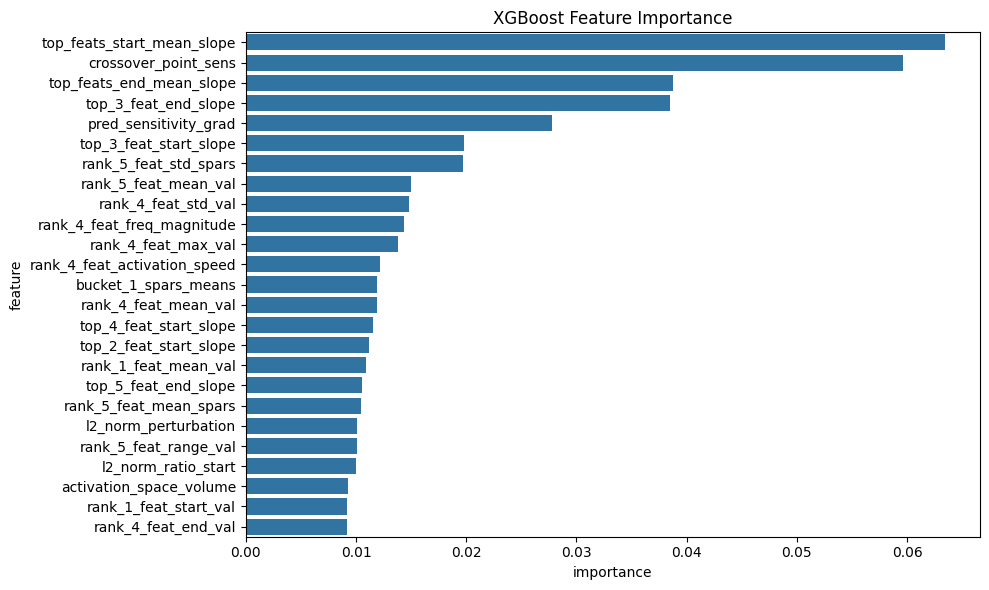

In [146]:
plot_feature_importance(reg_model, X, top_k=25)

### Feature cross correlation

In [147]:
def plot_correlation_matrix(X):
    corr_matrix = X.corr()
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix")
    plt.tight_layout()
    plt.show()

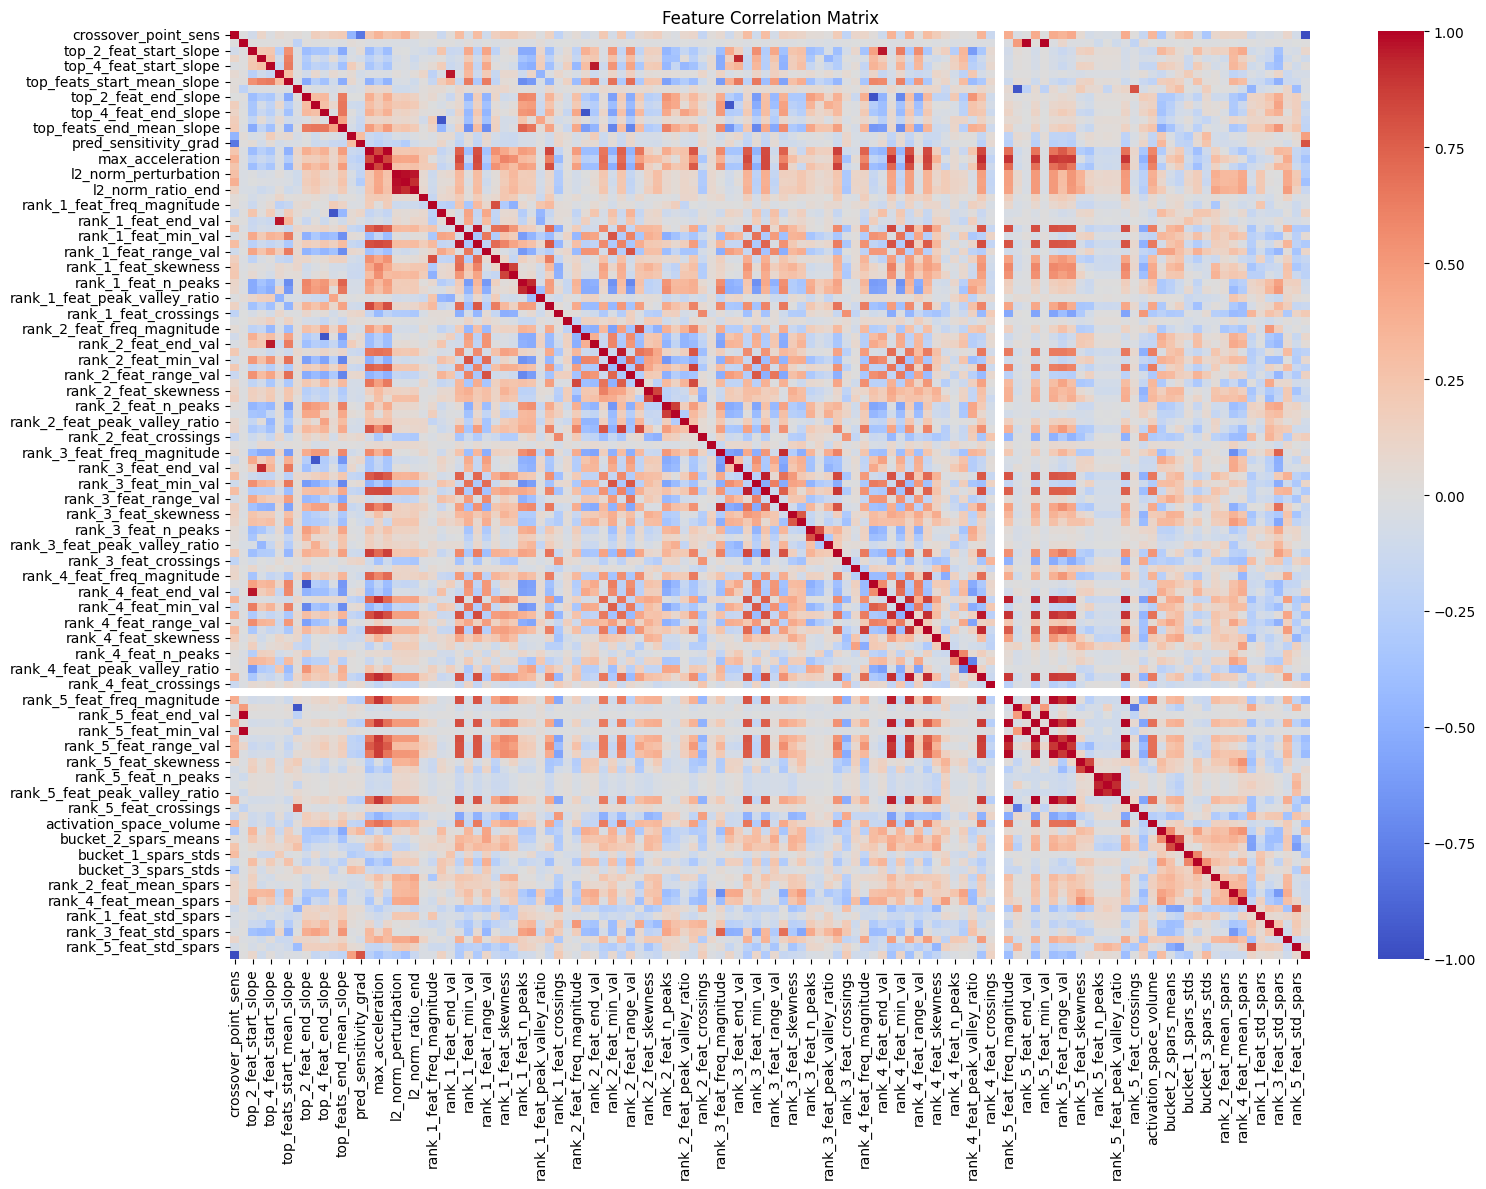

In [148]:
plot_correlation_matrix(X)

### Recursive Feature Elimination (RFE)

In [104]:
def perform_rfe(model, X, y, n_features_to_select=10):
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
    rfe = rfe.fit(X, y)
    return pd.Series(rfe.support_, index=X.columns)

In [105]:
rfe_support = perform_rfe(reg_model, X, y)
print("RFE selected features:", X.columns[rfe_support].tolist())

RFE selected features: ['crossover_point_sens', 'top_3_feat_start_slope', 'top_4_feat_start_slope', 'top_feats_start_mean_slope', 'top_3_feat_end_slope', 'top_feats_end_mean_slope', 'pred_sensitivity_grad', 'rank_4_feat_std_val', 'rank_5_feat_mean_spars', 'rank_5_feat_std_spars']


In [149]:
selected_columns = X.columns[rfe_support].tolist()

In [151]:
for f in selected_columns:
    print(f)

crossover_point_sens
top_3_feat_start_slope
top_4_feat_start_slope
top_feats_start_mean_slope
top_3_feat_end_slope
top_feats_end_mean_slope
pred_sensitivity_grad
rank_4_feat_std_val
rank_5_feat_mean_spars
rank_5_feat_std_spars


In [21]:
# selected_columns = ['crossover_point_sens', 'top_feats_start_mean_slope', 'rank_5_feat_std_spars', 'rank_1_feat_start_val']

In [152]:
X_selected = X[selected_columns]

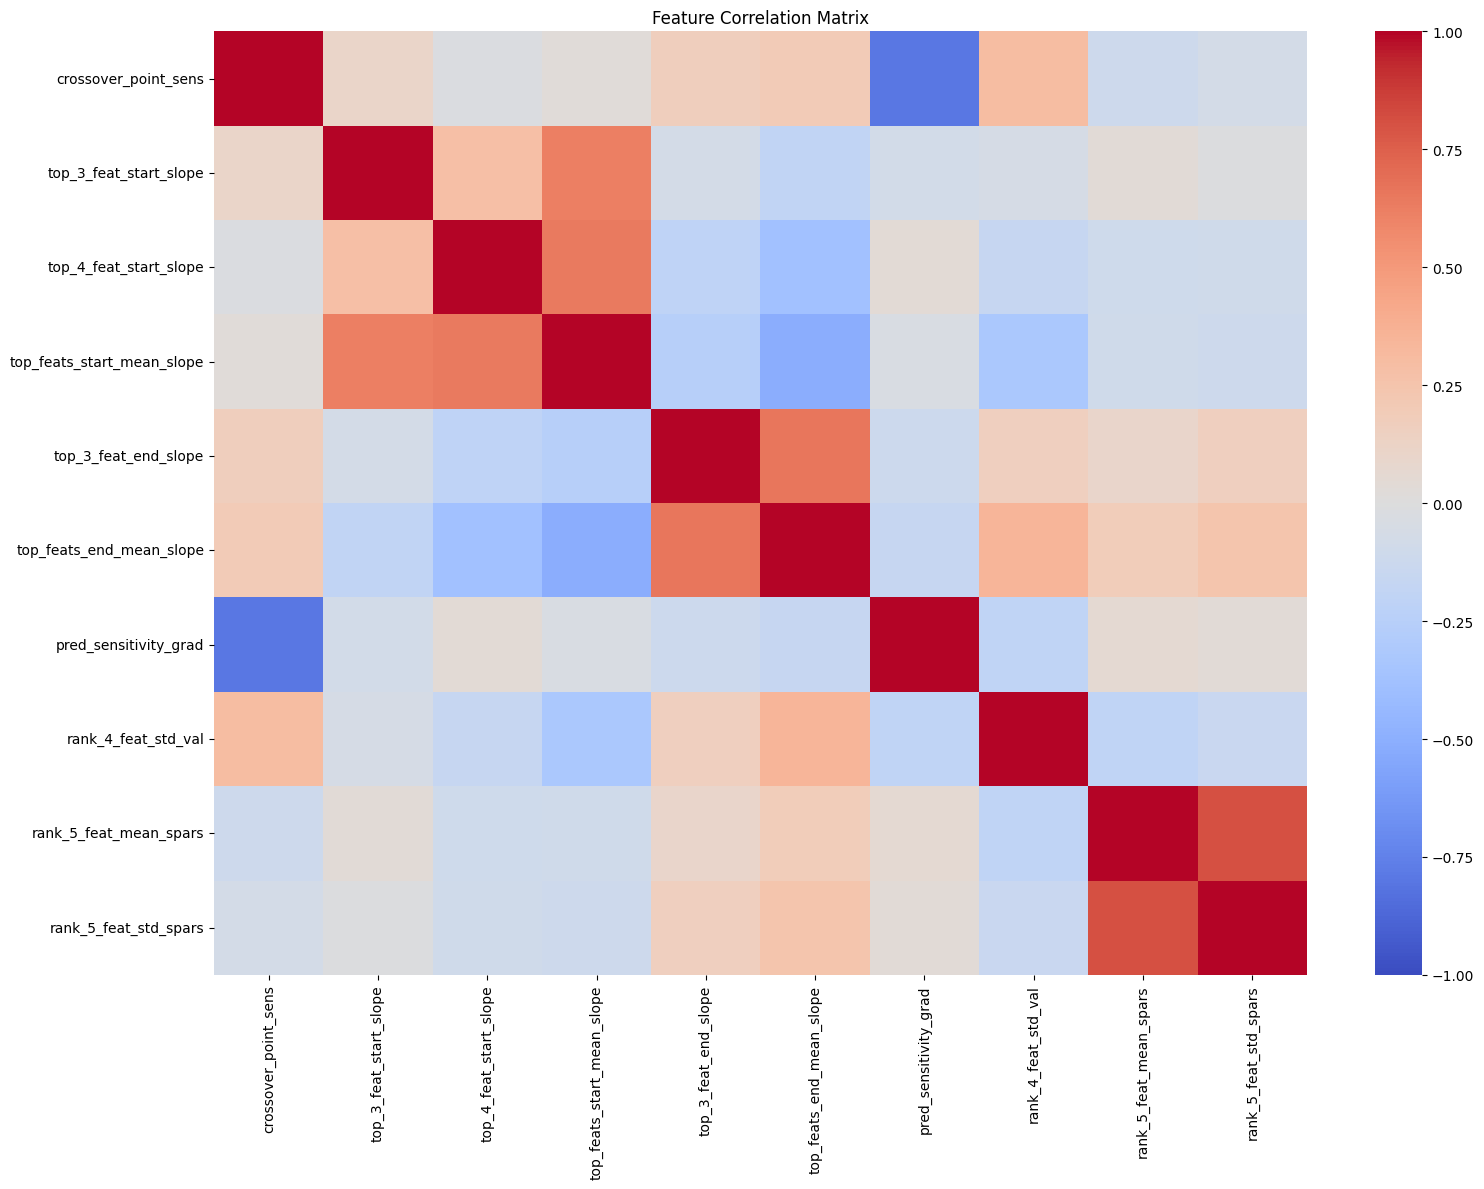

In [153]:
plot_correlation_matrix(X_selected)

In [154]:
indices = np.arange(X_selected.shape[0])

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X_selected, y, indices, test_size=0.2, random_state=113, shuffle=True
)

print(X_train.shape, X_test.shape)

(7903, 10) (1976, 10)


In [155]:
sel_model = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.01,
    min_child_weight=10,
    subsample=0.5,
    reg_alpha=0.2,
    reg_lambda=0.78,
    gamma=0.7,
    random_state=111,
    device="cuda",
)

In [156]:
sel_model.fit(X_train, y_train)

y_pred = sel_model.predict(X_train)
mse = mean_absolute_error(y_train, y_pred, multioutput="raw_values")[0]
r2 = r2_score(y_train, y_pred, multioutput="raw_values")[0]

print(f"Train MAE: {mse:.4f}")
print(f"Train R-squared: {r2:.4f}")

Train MAE: 2.7168
Train R-squared: 0.5349


In [157]:
y_pred_test = sel_model.predict(X_test)

mse = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"MAE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

MAE: 2.9880
R-squared: 0.4605


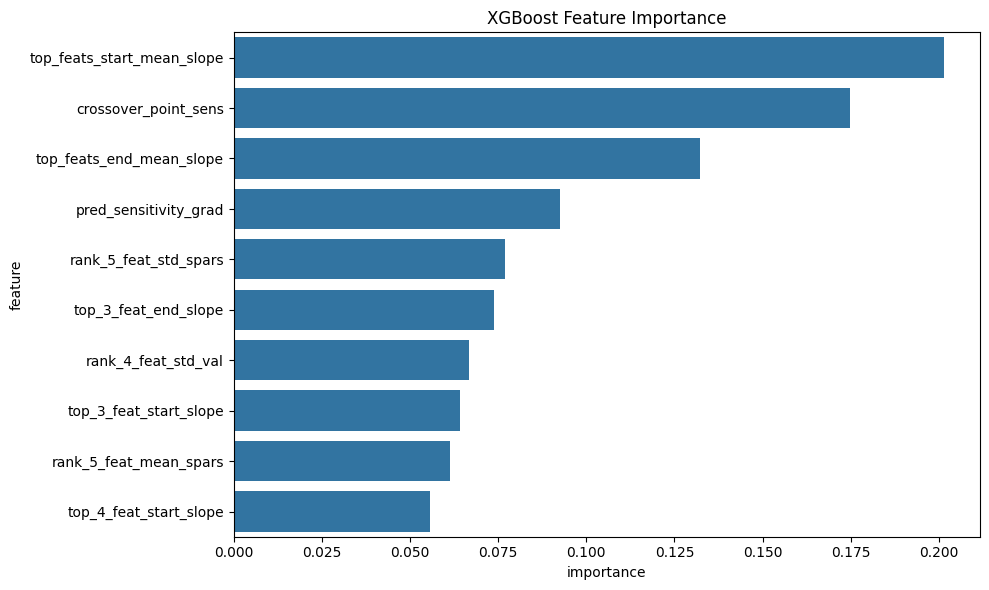

In [158]:
plot_feature_importance(sel_model, X_selected)

### Feature Selection based on performance

In [172]:
def forward_feature_selection(model, X, y, max_features=10):
    features = []
    while len(features) < max_features:
        best_score = 0
        best_feature = None
        for feature in X.columns:
            if feature not in features:
                temp_features = features + [feature]
                score = np.mean(
                    cross_val_score(model, X[temp_features], y, cv=5, n_jobs=-1)
                )
                if score > best_score:
                    best_score = score
                    best_feature = feature
        if best_feature is not None:
            features.append(best_feature)
        else:
            break
    return features

In [173]:
forward_selected_features = forward_feature_selection(reg_model, X, y)
print("Forward selected features:", forward_selected_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

KeyboardInterrupt: 

In [161]:
# forward_selected_features = [
#     'rank_1_feat_start_val', 'rank_5_feat_end_val', 'rank_5_feat_start_val',
#     'rank_1_feat_end_val', 'l2_norm_ratio_start', 'rank_2_feat_start_val',
#     'rank_4_feat_std_spars', 'rank_4_feat_end_val', 'rank_4_feat_start_val',
#     'rank_5_feat_mean_spars'
# ]

# forward_selected_features = [
#     'rank_1_feat_start_val', # Start feat act of rank 1 feature
#     'rank_5_feat_start_val', # Start feat act of rank 5 feature
#     'l2_norm_ratio_start', # Ratio of perturbation to starting activation
#     'rank_5_feat_mean_spars', # Mean sparsity of features in rank 5
#     'crossover_point_sens' # Cross over point of top feature from A and top feature from T
# ]

In [162]:
X_selected = X[forward_selected_features]

In [163]:
indices = np.arange(X_selected.shape[0])

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X_selected, y, indices, test_size=0.2, random_state=113, shuffle=True
)

print(X_train.shape, X_test.shape)

(7903, 5) (1976, 5)


In [167]:
sel_model = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.01,
    min_child_weight=10,
    subsample=0.5,
    reg_alpha=0.2,
    reg_lambda=0.78,
    gamma=0.7,
    random_state=111,
    device="cuda",
)

In [168]:
sel_model.fit(X_train, y_train)

y_pred = sel_model.predict(X_train)
mse = mean_absolute_error(y_train, y_pred, multioutput="raw_values")[0]
r2 = r2_score(y_train, y_pred, multioutput="raw_values")[0]

print(f"Train MAE: {mse:.4f}")
print(f"Train R-squared: {r2:.4f}")

Train MAE: 3.0197
Train R-squared: 0.4274


In [169]:
y_pred_test = sel_model.predict(X_test)

mse = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"MAE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

MAE: 3.2352
R-squared: 0.3764


In [209]:
# plot_feature_importance(sel_model, X_selected)

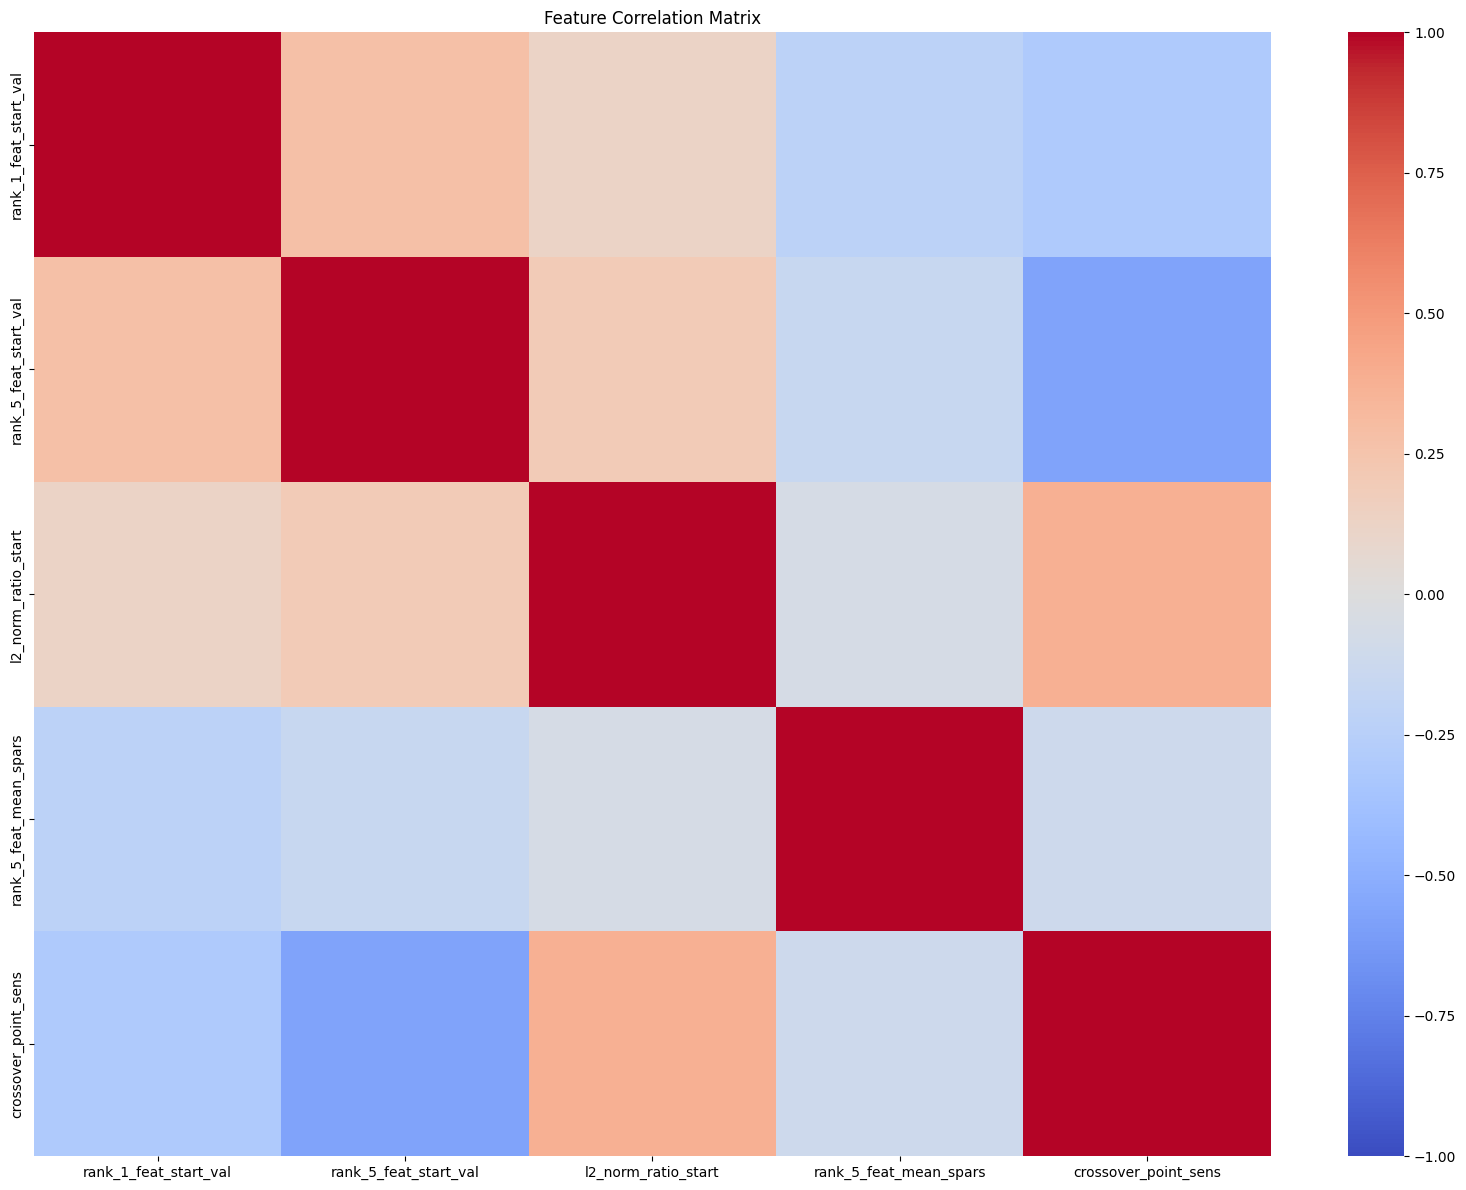

In [210]:
plot_correlation_matrix(X_selected)

## Visualise Model

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
import shap


import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import numpy as np


def plot_partial_dependence(model, X, n_features=5, figsize=(20, 15)):
    """
    Plot partial dependence for the top N features.

    Args:
    model: Trained XGBoost model
    X: pandas DataFrame with the feature data
    n_features: Number of top features to plot (default 10)
    figsize: Size of the figure (default (20, 15))
    """
    try:
        # Get feature importances
        importance = model.get_booster().get_score(importance_type="gain")

        # Sort features by importance
        sorted_features = sorted(importance, key=importance.get, reverse=True)

        # Select top N features
        features_to_plot = sorted_features[:n_features]

        # Calculate number of rows and columns for subplots
        n_cols = 3  # You can adjust this
        n_rows = (n_features + n_cols - 1) // n_cols

        # Create subplots
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        fig.suptitle("Partial Dependence Plots for Top Features", fontsize=16)

        # Flatten axes array for easy iteration
        axes = axes.flatten()

        # Plot partial dependence for each feature
        for i, feature in enumerate(features_to_plot):
            PartialDependenceDisplay.from_estimator(
                model, X, [feature], ax=axes[i], feature_names=X.columns.tolist()
            )
            axes[i].set_title(f"{feature}")
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel("Partial Dependence")

        # Remove any unused subplots
        for i in range(n_features, len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)  # Adjust to prevent title overlap
        plt.show()

    except Exception as e:
        print(f"Error in Partial Dependence Plots: {e}")


def plot_feature_interactions(model, X, feature_names):
    try:
        features_to_plot = feature_names[: min(3, len(feature_names))]
        for i, feat1 in enumerate(features_to_plot):
            for feat2 in features_to_plot[i + 1 :]:
                fig, ax = plt.subplots(figsize=(8, 6))
                PartialDependenceDisplay.from_estimator(
                    model, X, [feat1, feat2], ax=ax, kind="both"
                )
                plt.title(f"Partial Dependence Plot: {feat1} vs {feat2}")
                plt.tight_layout()
                plt.show()
    except Exception as e:
        print(f"Error in Feature Interactions plot: {e}")


def plot_shap_summary(model, X, feature_names, max_display=30):
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
        if shap_values is None:
            raise ValueError("SHAP values are None")

        plt.figure(figsize=(12, 8))
        plt.title("SHAP Summary Plot")
        shap.summary_plot(
            shap_values, X, feature_names=feature_names, max_display=max_display
        )

        # plt.tight_layout()
        # plt.show()
    except Exception as e:
        print(f"Error in SHAP summary plot: {e}")
        print(
            "SHAP values shape:",
            np.shape(shap_values) if shap_values is not None else "None",
        )
        print("X shape:", X.shape)


def plot_shap_dependence(model, X, feature_names):
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
        features_to_plot = feature_names[: min(10, len(feature_names))]
        for feature in features_to_plot:
            shap.dependence_plot(feature, shap_values, X, feature_names=feature_names)
            # plt.title(f'SHAP Dependence Plot for {feature}')
            # plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error in SHAP dependence plots: {e}")


def plot_custom_feature_importance(model, feature_names, max_display=20):
    importance = model.get_booster().get_score(importance_type="gain")
    sorted_idx = np.argsort(list(importance.values()))[-max_display:]
    fig, ax = plt.subplots(figsize=(12, min(len(importance), max_display) * 0.3))
    y_pos = np.arange(len(sorted_idx))
    ax.barh(
        y_pos, [importance.get(feature_names[i], 0) for i in sorted_idx], align="center"
    )
    ax.set_yticks(y_pos)
    ax.set_yticklabels([feature_names[i] for i in sorted_idx])
    ax.invert_yaxis()
    ax.set_title("Feature Importance (Selected Features)")
    plt.tight_layout()
    plt.show()


def plot_advanced_partial_dependence(
    model, X, features, feature_names=None, figsize=(16, 10)
):
    """
    Plot advanced partial dependence for the specified features.

    Args:
    model: Trained model (e.g., HistGradientBoostingRegressor)
    X: pandas DataFrame with the feature data
    features: List of features or tuples of features to plot
    feature_names: List of feature names (optional)
    figsize: Size of the figure (default (16, 10))
    """
    n_features = len(features)
    fig, axes = plt.subplots(1, n_features, figsize=figsize)
    if n_features == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        if isinstance(feature, tuple):
            # Two-way partial dependence plot
            PartialDependenceDisplay.from_estimator(
                model,
                X,
                [feature],
                ax=axes[i],
                feature_names=feature_names,
                kind="average",
                contour_kw={"cmap": "viridis"},
                grid_resolution=50,
            )
            axes[i].set_title(f"Partial dependence of {feature[0]} and {feature[1]}")
        else:
            # One-way partial dependence plot
            PartialDependenceDisplay.from_estimator(
                model,
                X,
                [feature],
                ax=axes[i],
                feature_names=feature_names,
                kind="average",
                pd_line_kw={"color": "blue", "label": "average"},
                ice_lines_kw={
                    "color": "cyan",
                    "alpha": 0.2,
                    "linewidth": 0.5,
                    "label": "individual",
                },
            )
            axes[i].set_title(f"Partial dependence of {feature}")
            axes[i].grid(True, which="major", linestyle="--", color="gray", alpha=0.5)
            axes[i].legend()

    plt.tight_layout()
    plt.show()

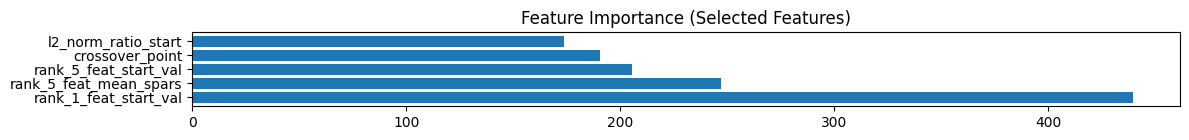

In [232]:
plot_custom_feature_importance(sel_model, forward_selected_features)

In [239]:
forward_selected_features

['rank_1_feat_start_val',
 'rank_5_feat_start_val',
 'l2_norm_ratio_start',
 'rank_5_feat_mean_spars',
 'crossover_point']

/tmp/ipykernel_3318/3266695018.py:173: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipykernel_3318/3266695018.py:173: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


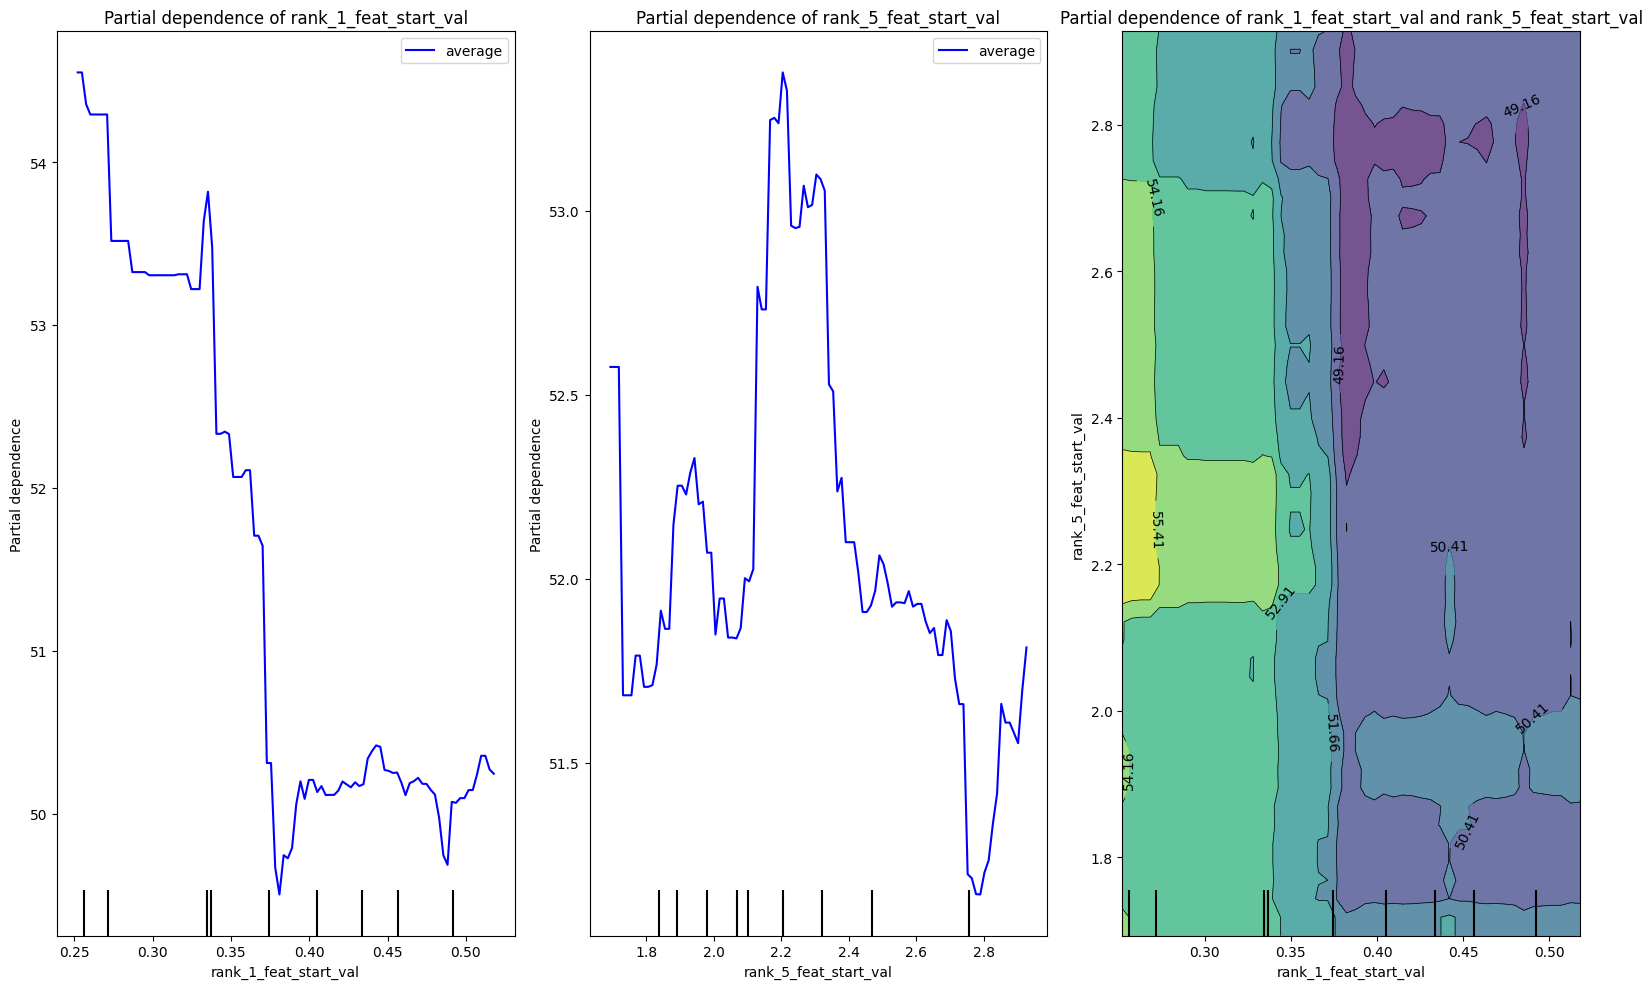

In [240]:
# plot_partial_dependence(sel_model, X_selected, n_features=5)

features_to_plot = [
    "rank_1_feat_start_val",
    "rank_5_feat_start_val",
    ("rank_1_feat_start_val", "rank_5_feat_start_val"),
]
plot_advanced_partial_dependence(
    sel_model, X_selected, features_to_plot, forward_selected_features
)

In [219]:
# plot_feature_interactions(reg_model, X, feature_names)

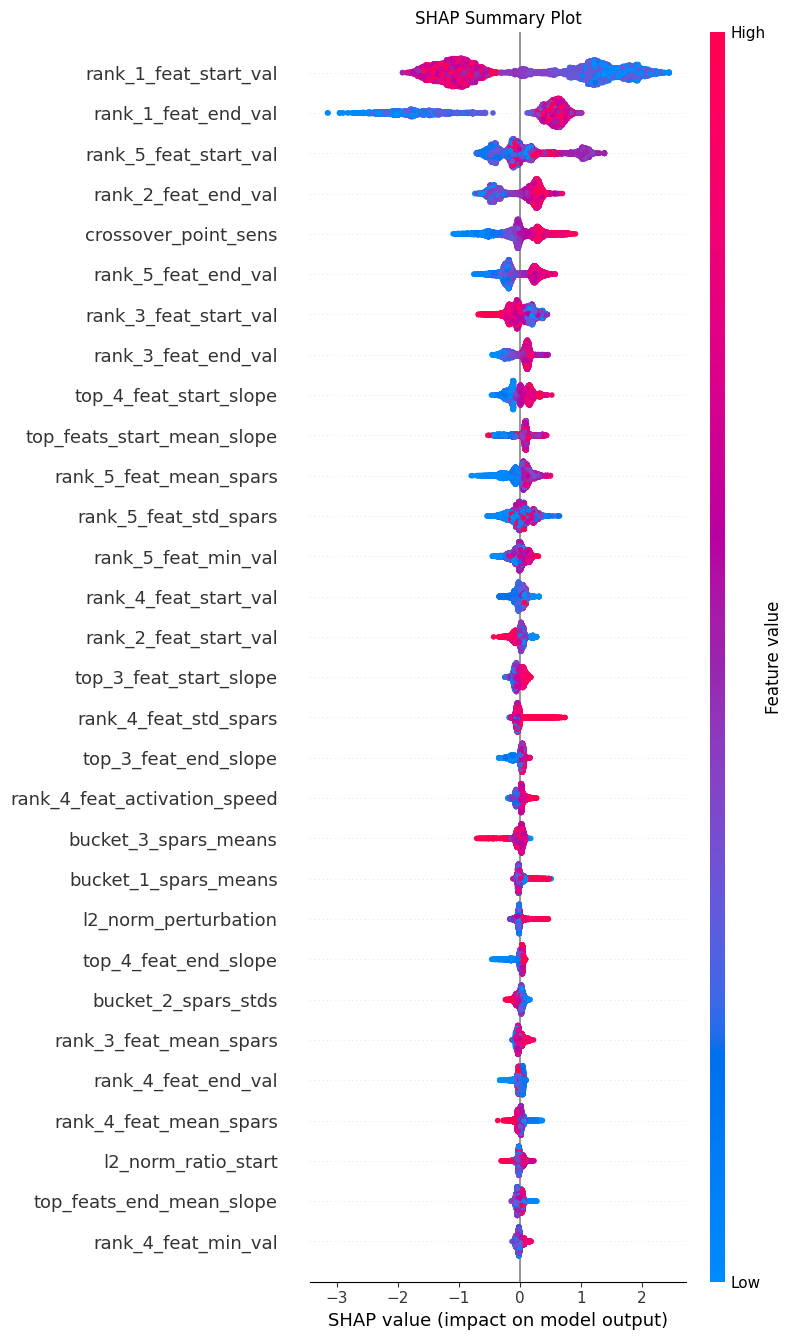

In [227]:
plot_shap_summary(reg_model, X, feature_names)

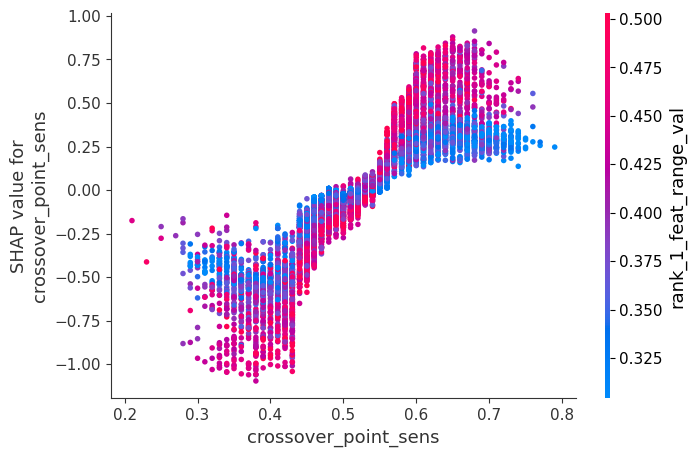

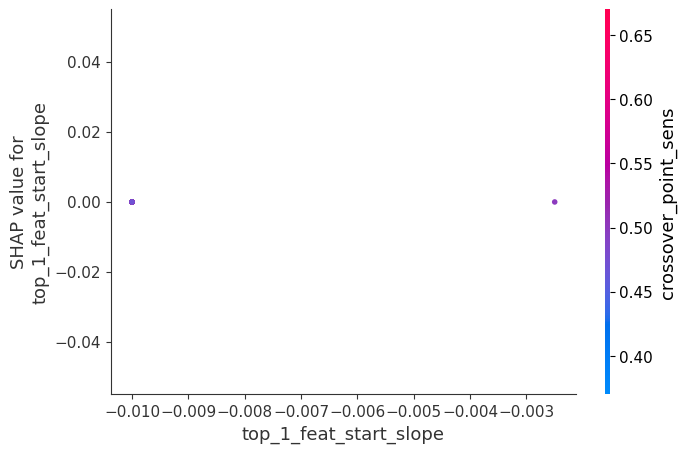

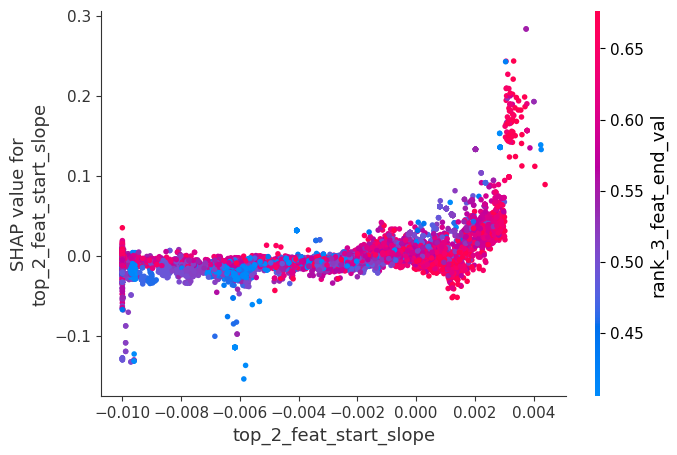

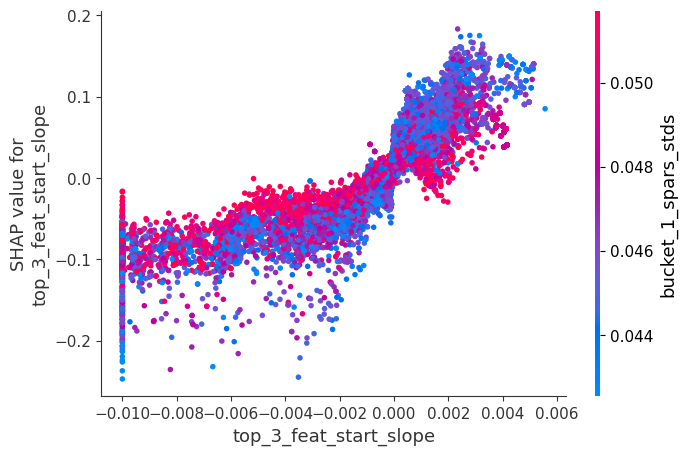

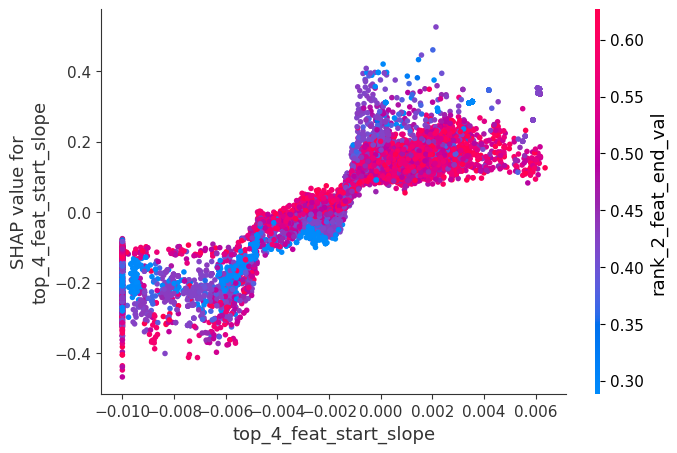

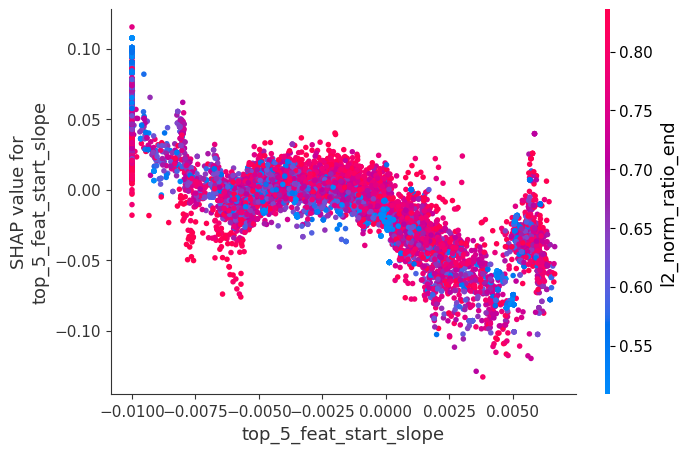

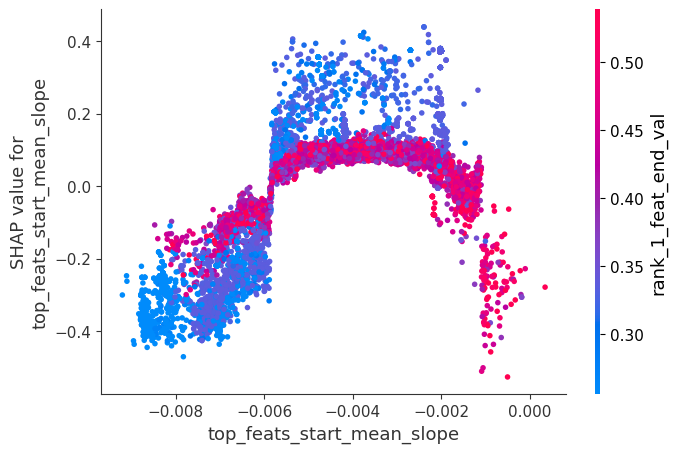

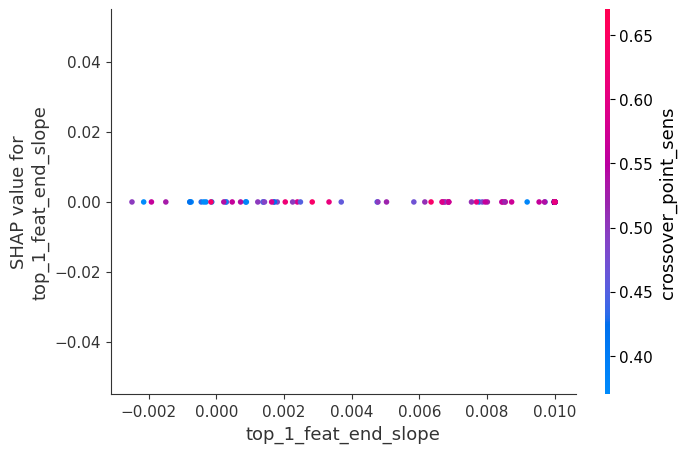

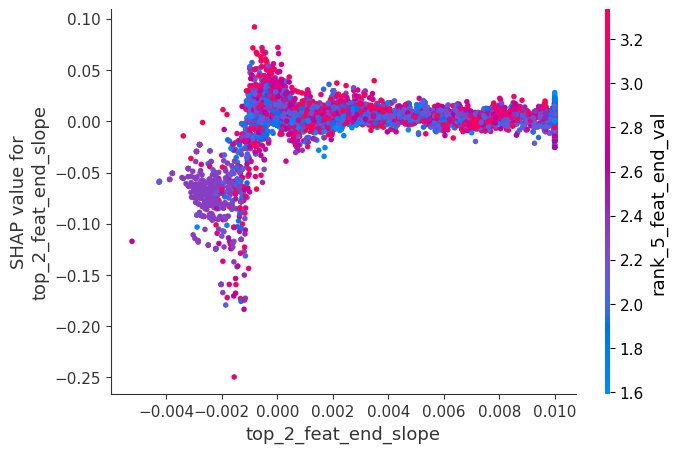

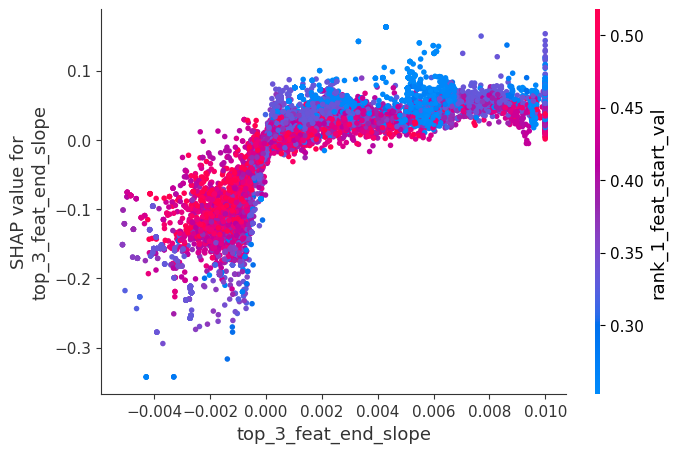

In [230]:
plot_shap_dependence(reg_model, X, feature_names)

## Exploring predictions

In [130]:
diffs = np.abs(np.array(y_test) - np.array(y_pred_test))

# diffs = np.abs(np.array(labels) - np.array(preds))
min_diff_idxs = np.argsort(-diffs).tolist()[-10:][::-1]
max_diff_idxs = np.argsort(diffs).tolist()[-10:][::-1]
max_diffs = diffs[max_diff_idxs]
min_diffs = diffs[min_diff_idxs]

In [180]:
random_diff_idxs = random.sample(range(len(diffs)), 10)

In [185]:
idx = random_diff_idxs[1]
original_idx = indices_test[idx]

step_js_dists = js_dists[original_idx]
js_blowup_step = js_blowup_steps[original_idx]
pred = y_pred_test[idx]

abs(pred - js_blowup_step)

5.8189849853515625

In [209]:
pred_df = pd.DataFrame(
    [{"pred": y_pred_test[i], "label": y_test[i]} for i in range(len(y_test))]
)

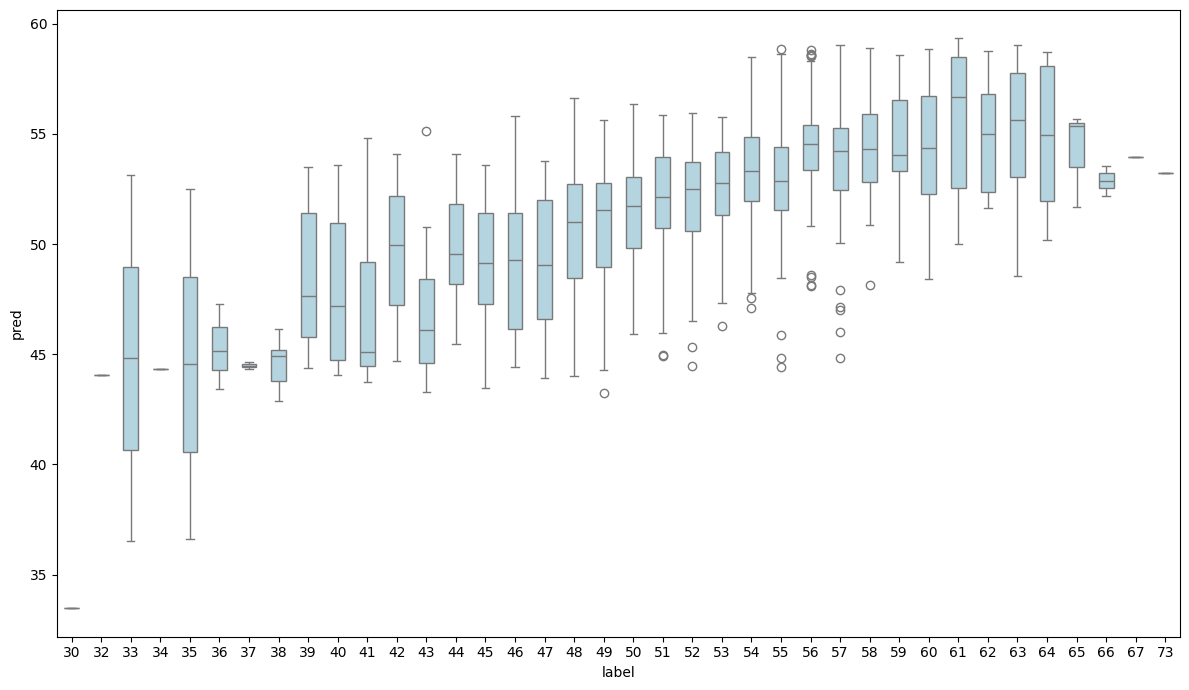

In [210]:
plt.figure(figsize=(12, 7))
sns.boxplot(x="label", y="pred", data=pred_df, color="lightblue", width=0.5)

plt.tight_layout()
plt.show()

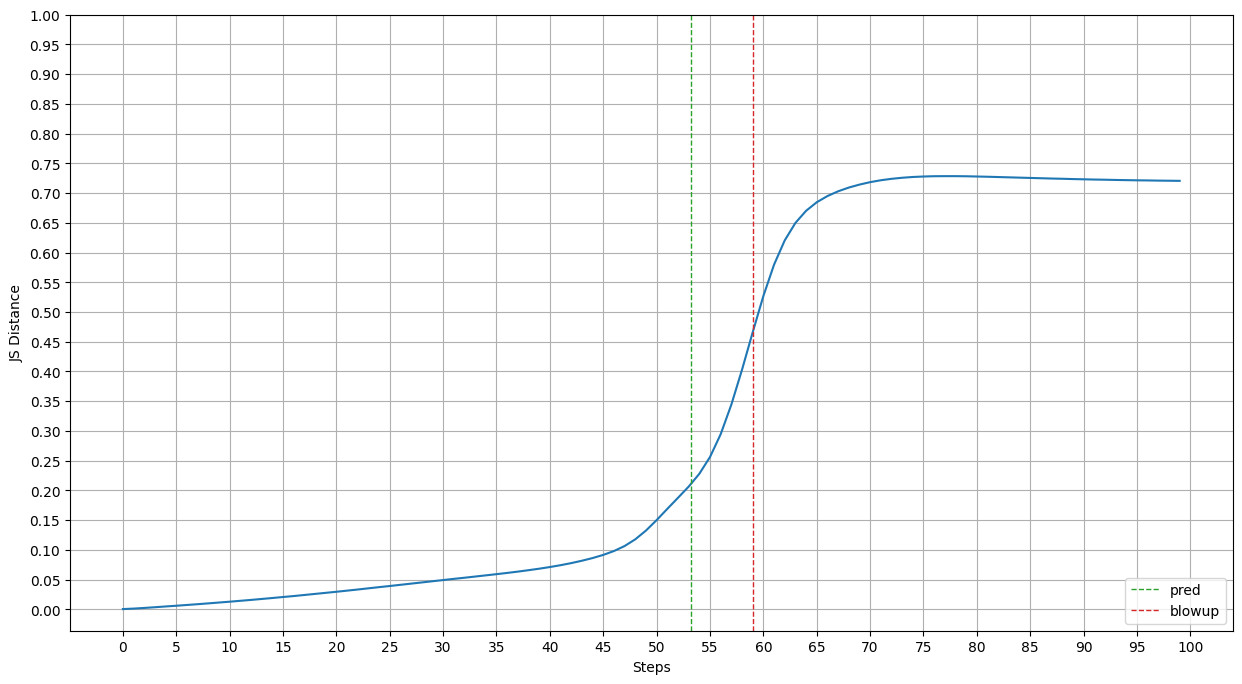

In [211]:
plt.figure(figsize=(15, 8))
plt.plot(step_js_dists)
plt.axvline(x=pred, color="tab:green", linestyle="--", linewidth=1, label="pred")

plt.axvline(
    x=js_blowup_step, color="tab:red", linestyle="--", linewidth=1, label="blowup"
)

plt.yticks(np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(0, 105, 5))
plt.xlabel("Steps")
plt.ylabel("JS Distance")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# plot_heatmap_feature_acts(feature_acts, step_js_dists)

## Optimise Model

In [55]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import cupy as cp
import random

In [68]:
def objective(trial, X, y, n_folds=5):
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        # 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0),
    }

    model = XGBRegressor(**params, device="cuda", random_state=42)

    # Convert CuPy arrays to NumPy for sklearn compatibility
    X_np = cp.asnumpy(X) if isinstance(X, cp.ndarray) else X
    y_np = cp.asnumpy(y) if isinstance(y, cp.ndarray) else y

    # Perform cross-validation
    scores = cross_val_score(
        model, X_np, y_np, cv=n_folds, scoring="neg_mean_squared_error"
    )
    return -scores.mean()  # Return negative MSE for minimization


def optimize_xgboost(X, y, n_trials=100, n_folds=5):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X, y, n_folds), n_trials=n_trials)

    best_params = study.best_params
    best_score = -study.best_value

    print("Best parameters found:")
    for key, value in best_params.items():
        print(f"    {key}: {value}")
    print(f"Best cross-validation MSE: {best_score:.4f}")

    # Train the final model with the best parameters
    best_model = XGBRegressor(**best_params, device="cuda", random_state=42)

    # Convert CuPy arrays to NumPy for final fitting
    X_np = cp.asnumpy(X) if isinstance(X, cp.ndarray) else X
    y_np = cp.asnumpy(y) if isinstance(y, cp.ndarray) else y

    best_model.fit(X_np, y_np)

    return best_model, best_params, best_score

In [66]:
sample_idxs = random.sample(range(X.shape[0]), 1000)
X_sample = X[sample_idxs]
y_sample = y[sample_idxs]

In [69]:
best_model, best_params, best_score = optimize_xgboost(X_sample, y_sample, n_trials=100)

# To make predictions (assuming X_test is your test data)
X_test_np = cp.asnumpy(X_test) if isinstance(X_test, cp.ndarray) else X_test
y_pred = best_model.predict(X_test_np)

# Evaluate on test set
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

[I 2024-08-13 21:42:17,107] A new study created in memory with name: no-name-f92f632f-111d-431e-9445-aa70ce93170f
[I 2024-08-13 21:42:20,198] Trial 0 finished with value: 47.89097405694122 and parameters: {'max_depth': 5, 'learning_rate': 0.9138755095155152, 'n_estimators': 647, 'min_child_weight': 3, 'subsample': 0.7356303939960191, 'gamma': 0.5869021980899037, 'reg_alpha': 0.19240918674636312, 'reg_lambda': 0.6607794699923992}. Best is trial 0 with value: 47.89097405694122.
[I 2024-08-13 21:42:20,781] Trial 1 finished with value: 28.252701445334775 and parameters: {'max_depth': 1, 'learning_rate': 0.4639075490076031, 'n_estimators': 329, 'min_child_weight': 3, 'subsample': 0.6020977386064515, 'gamma': 0.37988800596250893, 'reg_alpha': 0.059715330160210425, 'reg_lambda': 0.10968200459462024}. Best is trial 1 with value: 28.252701445334775.
[I 2024-08-13 21:42:25,245] Trial 2 finished with value: 30.34344147881712 and parameters: {'max_depth': 8, 'learning_rate': 0.4207071072614939, 'n

Best parameters found:
    max_depth: 2
    learning_rate: 0.016999397686573485
    n_estimators: 755
    min_child_weight: 5
    subsample: 0.5317797272115067
    gamma: 0.7078385362152435
    reg_alpha: 0.1931275318075108
    reg_lambda: 0.7834273806164702
Best cross-validation MSE: -23.3392
Test MSE: 25.6950
